## Bayesian Modelling in Python
Mark Regan

---

### Section 0: Introduction
Welcome to "Bayesian Modelling in Python" - a tutorial for those interested in learning Bayesian statistics in Python. You can find a list of all tutorial sections on the project's [homepage](https://github.com/markdregan/Hangout-with-PyMC3).

Statistics is a topic that never resonated with me throughout my years in university. The frequentist techniques that we were taught (p-values, etc.) felt contrived and ultimately, I turned my back on statistics as a topic that I wasn't interested in.

That was until I stumbled upon Bayesian statistics - a branch of statistics quite different from the traditional frequentist statistics that most universities teach. I was inspired by a number of different publications, blogs & videos that I would highly recommend any newbies to Bayesian stats to begin with. They include:
- [Doing Bayesian Data Analysis](http://www.amazon.com/Doing-Bayesian-Analysis-Second-Edition/dp/0124058884/ref=dp_ob_title_bk) by John Kruschke
- [Python port](https://github.com/aloctavodia/Doing_Bayesian_data_analysis) of John Kruschke's examples by Osvaldo Martin
- [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) provided me with a great source of inspiration to learn Bayesian stats. In recognition of this influence, I've adopted the same visual styles as BMH.
- [While My MCMC Gently Samples](http://twiecki.github.io/) blog by Thomas Wiecki
- [Healthy Algorithms](http://healthyalgorithms.com/tag/pymc/) blog by Abraham Flaxman
- [Scipy Tutorial 2014](https://github.com/fonnesbeck/scipy2014_tutorial) by Chris Fonnesbeck

I created this tutorial in the hope that others find it useful and it helps them learn Bayesian techniques just like the above resources helped me. I'd welcome any corrections/comments/contributions from the community.

---

### Loading your Google Hangout chat data
Throughout this tutorial, we will use a dataset containing all of my Google Hangout chat messages. I've removed the messages content and anonymized my friends' names; the rest of the dataset is unaltered.

If you'd like to use your Hangout chat data whilst working through this tutorial, you can download your Google Hangout data from [Google Takeout](https://www.google.com/settings/takeout/custom/chat). The Hangout data is downloadable in JSON format. After downloading, you can replace the `hangouts.json` file in the data folder.

The json file is heavily nested and contains a lot of redundant information. Some of the key fields are summarized below:

| Field           | Description                                                    | Example                                      |
|-----------------|----------------------------------------------------------------|----------------------------------------------|
| `conversation_id` | Conversation id representing the chat thread                   | Ugw5Xrm3ZO5mzAfKB7V4AaABAQ                   |
| `participants`    | List of participants in the chat thread                        | [Mark, Peter, John]                          |
| `event_id`        | Id representing an event such as chat message or video hangout | 7-H0Z7-FkyB7-H0au2avdw                       |
| `timestamp`       | Timestamp                                                      | 2014-08-15 01:54:12                          |
| `message`         | Content of the message sent                                    | Went to the local wedding photographer today |
| `sender`          | Sender of the message                                          | Mark Regan                                   |

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns

from datetime import datetime

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

The below code loads the json data and parses each message into a single row in a pandas DataFrame.
> Note: the data/ directory is missing the hangouts.json file. You must download and add your own JSON file as described above. Alternatively, you can skip to the next section where I import an anonymized dataset.

In [16]:
# Import json data
messages = pd.read_csv("../data/hangout_chat_data.csv", sep=',').sort_values(['conversation_id', 'timestamp'])
messages.head(5)

,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 03:44:12.840015,Mark Regan,14,3,TEXT,2014-08-15 03:44:00.781653,Keir Alexander,12.0,1.0,4,2014-08,0
1,UgwLUkm5oqPrUyjqFlR4AaABAQ,85SWvmXIEV285Sb1E65xL0,2015-10-18 09:36:39.438706,Mark Regan,47,4,TEXT,2015-10-18 09:36:10.932367,Louise Regan,28.0,1.0,6,2015-10,1
2,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1JJEmE5K,2013-12-19 02:49:28.552063,Mark Regan,44,2,TEXT,2013-12-19 02:48:50.916592,Daragh Walsh,37.0,1.0,3,2013-12,0
3,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1NQV6lMv,2013-12-19 02:50:02.249113,Mark Regan,29,2,TEXT,2013-12-19 02:49:50.401824,Daragh Walsh,11.0,1.0,3,2013-12,0
4,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1RPd1OTh,2013-12-19 02:50:34.906922,Mark Regan,102,2,TEXT,2013-12-19 02:50:11.427353,Daragh Walsh,23.0,1.0,3,2013-12,0


In [20]:
# Remove messages not responded within 60 seconds
# This introduces an issue by right censoring the data (might return to address)
messages = messages[messages['time_delay_seconds'] < 60]
messages.head(1)

,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 03:44:12.840015,Mark Regan,14,3,TEXT,2014-08-15 03:44:00.781653,Keir Alexander,12.0,1.0,4,2014-08,0


We now have a data model that we can work with more easily. The above table shows a single row in the pandas DataFrame. I'm interested in how long it takes me to respond to messages. Let's create some plots that describe my typical response times.

C:\Anaconda\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


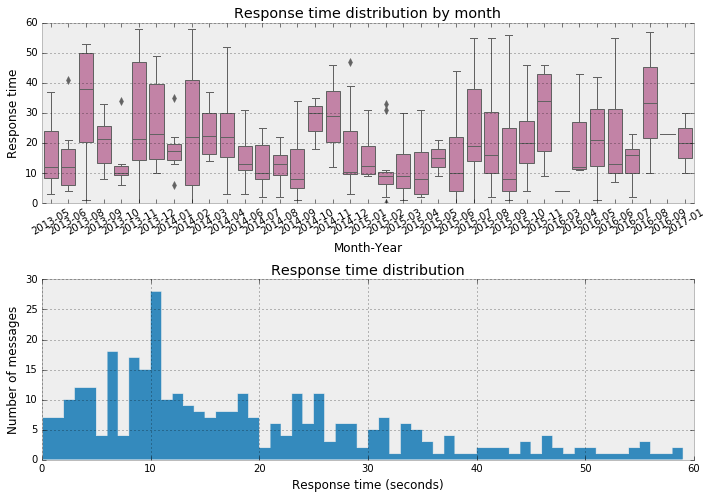

In [21]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(211)

order = np.sort(messages['year_month'].unique())
sns.boxplot(x=messages['year_month'], y=messages['time_delay_seconds'], order=order, orient="v", color=colors[5], linewidth=1, ax=ax)
_ = ax.set_title('Response time distribution by month')
_ = ax.set_xlabel('Month-Year')
_ = ax.set_ylabel('Response time')
_ = plt.xticks(rotation=30)

ax = fig.add_subplot(212)
plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled', color=colors[0])
_ = ax.set_title('Response time distribution')
_ = ax.set_xlabel('Response time (seconds)')
_ = ax.set_ylabel('Number of messages')

plt.tight_layout()

The above plots give a monthly and an overall perspective of the length of time (in seconds) that it takes me to respond to messages. At this point I have a lot of questions that I want to ask of the data. For example:
1. Is my response time affected by who I am talking to?
2. Are there environmental factors that affect my response time (day of week, location, etc.)?
3. What is the best and worst day to get in touch with me?

Before we try and answer some of these questions, lets take some baby steps by estimating some parameters of a model that describes the above data. That'll make it easier for us to understand the data and inquire further.

In the next section, we'll estimate parameters that describe the above distribution.

#### [>> Go to the Next Section](http://nbviewer.ipython.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%201.%20Estimating%20model%20parameters.ipynb)

### Export data for usage throughout tutorial

### References
1. [Hangout reader](https://bitbucket.org/dotcs/hangouts-log-reader/) by Fabian Mueller

In [6]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()